***ECE563: AI in Smart Grid***

Arturo Galofré (A20521022)

# **Introduction**

This project aims to predict the load values for the week of June 1-7, 2008, for 20 different zones in the US, given the temperature data and historical load data. The project will begin with exploring patterns and correlations between the temperature stations and the load values of each zone. If there is a strong correlation, then the temperature data of that station will be used to predict the load values of that specific zone. If there is no strong correlation, a machine learning algorithm will be used with a methodology described to choose a temperature station to predict the load values of each zone.

The project will then explore the datasets using at least two different machine learning algorithms. The first algorithm will be relatively simple and fast to allow exploring the problem and the data, and the second algorithm will be more complex to achieve better performance. Both models will be tuned to get the best possible performance based on training and validation data.

The project will analyze the results of the two different models in terms of CPU time and accuracy and choose the best model to predict the load values for the week of June 1-7, 2008. The performance of the chosen model will be explained, and the load values of the specific week will be predicted using the best model.

Following this brief introduction, the libraries as well as the created functions needed for the remaining of the project will be loaded with the following Python script.

In [2]:
# import libraries
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.utils import Bunch
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor


In [3]:
# Functions:

# Removing outliers
def remove_outliers(df, column_name, sd_multiplier=3):

 # Compute the mean and standard deviation of the column
    column_mean = df[column_name].mean()
    column_std = df[column_name].std()
    
    # Compute the lower and upper bounds for outlier removal
    lower_bound = column_mean - (sd_multiplier * column_std)
    upper_bound = column_mean + (sd_multiplier * column_std)
    
    # Create a copy of the DataFrame with outliers and zeros removed
    cleaned_df = df.loc[(df[column_name] > lower_bound) & (df[column_name] < upper_bound) & (df[column_name] != 0)].copy()
    
    return cleaned_df

# Dataframe to Bunch
def df_to_bunch(df):
    # Get the feature names
    feature_names = df.columns.tolist()

    # Get the target variable name
    target_name = feature_names.pop(-1)

    # Get the feature data and target data
    data = df[feature_names].values
    target = df[target_name].values

    # Create a Bunch object
    bunch = Bunch(data=data, target=target,
                  feature_names=feature_names, target_names=target_name)

    return bunch


# **Data Processing**

Once the libraries have been loaded, the input data will be restructured. Instead of having 24 different columns, each one containing the values of temperature and load for each hour of the day. It's been decided to delete the **h1** to **h24** columns and substitude them for two columns, one containing the different hours of the day with values ranging from 1 to 24 and one containing the corresponding temperature and load values for that specific hour. This will considerably increase the number of rows of each of the arrays, but it was considered to be easier to work with for the rest of the report. Instead of running through the whole data frame, the method **".melt()"** was used, which considerably reduced the reshaping of the data.

As for the amount of data that will be employed for solving the problem, it's been seen that by using the complete dataset, the training and managing of the data stays within reasonable time frames, and therefore it's decided that the whole dataset will be used for the project.

In [4]:
# Load the dataset
temp_data = pd.read_csv(
    '/Users/arturogalofre/Desktop/IIT/2nd_Term/ECE563_AISmartGrid/Code/FinalProject/Temp_history_final.csv')
load_data = pd.read_csv(
    '/Users/arturogalofre/Desktop/IIT/2nd_Term/ECE563_AISmartGrid/Code/FinalProject/Load_history_final.csv')

# Melt the temperature columns into a new DataFrame
temp_df = pd.melt(
    temp_data,
    id_vars=['station_id', 'year', 'month', 'day'],
    value_vars=['h{}'.format(i) for i in range(1, 25)],
    var_name='hour',
    value_name='temp'
)
temp_df['hour'] = temp_df['hour'].str.slice(start=1).astype(int)

# Melt the load columns into a new DataFrame
load_df = pd.melt(
    load_data,
    id_vars=['zone_id', 'year', 'month', 'day'],
    value_vars=['h{}'.format(i) for i in range(1, 25)],
    var_name='hour',
    value_name='load'
)
load_df['hour'] = load_df['hour'].str.slice(start=1).astype(int)

# Example of new data format & other outputs
print('New structure for Temperature and Load DataFrames, respectively:')
print(temp_df.head(1))
print(load_df.head(1))
print(f'The initial size of the Temperature and Load DataFrames was {temp_data.shape[0]} and {load_data.shape[0]}, which was then increased to {temp_df.shape[0]} and {load_df.shape[0]} respectively.')

New structure for Temperature and Load DataFrames, respectively:
   station_id  year  month  day  hour  temp
0           1  2004      1    1     1    43
   zone_id  year  month  day  hour    load
0        1  2004      1    1     1  542169
The initial size of the Temperature and Load DataFrames was 17820 and 32400, which was then increased to 427680 and 777600 respectively.


## **Assigning temperature stations to load zones for predicting load values based on temperature data**

Different approaches were taken to solve the problem of assigning the temperature stations to the corresponding load zones. The method used was based on the correlation between the load and temperature data, therefore, the more correlated the two sets of data the more likely a station was to be in a certain zone. As will be shown in the following figures, the correlation values are higher when the temperatures are more extreme, which occurs in winter and summer. In this two seasons the temperatures tend to be lower and higher than usual thus requiring heat pumps and refrigeration systems to be used and increase the load requirements. The first approach was to plot the correlation values between temperature and load for every month in the year, but in order to ease the computational burden of the process, the four seasons of the year were used, assigning 3 months to each of them.

| Season        | Months |
| :-----------: | :---: |
| Spring  | March, April, May  |
| Summer    | June, July, August  |
| Fall | September, October, November  |
| Winter | December, January, February  |

The following block of code creates a list with the correlation values between temperature and load for each season between all stations and zones. From the correlations graphs presented, it can be observed that the seasons with more extreme temperatures do in fact have higher correlation indexes.

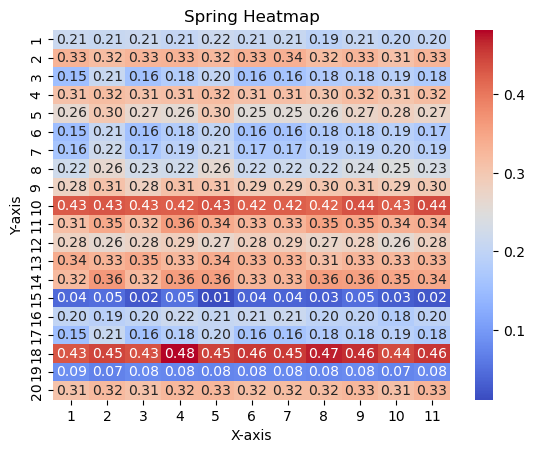

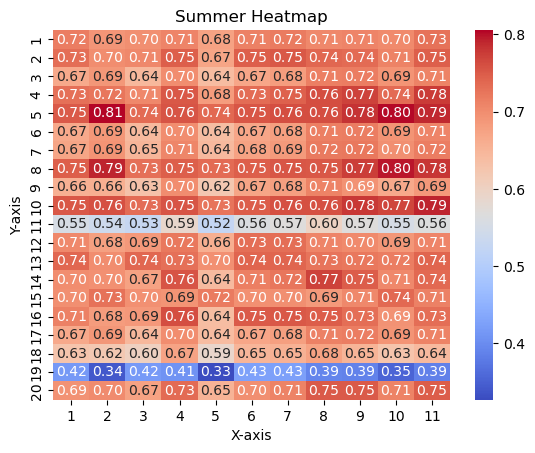

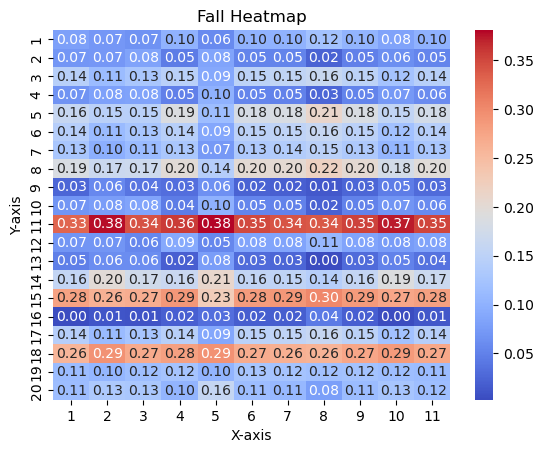

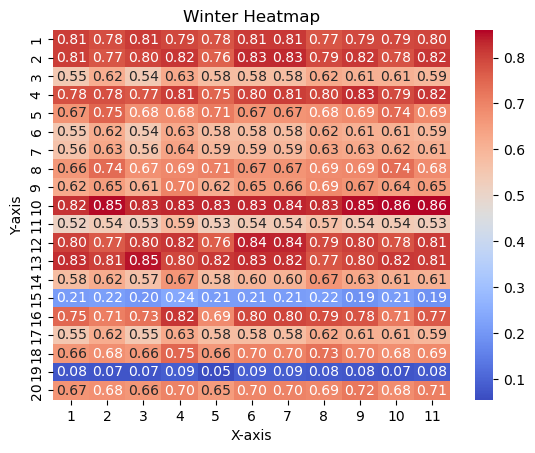

In [5]:
# Load the data
temp_data = temp_df
load_data = load_df

spring = [3, 4, 5]
summer = [6, 7, 8]
fall = [9, 10, 11]
winter = [12, 1, 2]
seasons = [spring, summer, fall, winter]
seasons_n = ['Spring', 'Summer', 'Fall', 'Winter']

corrf = []
for i in seasons:
    corr_list = []
    # Loop over each station
    for zone_id in range(1, 21):
        # Select the temperature data for the current station
        zone_load_data = load_data[load_data['zone_id']
                                   == zone_id]
        zone_load_data = zone_load_data[zone_load_data['month'].isin(i)]
        zone_load_data = zone_load_data['load']

        # Loop over each zone
        corr_sublist = []
        for station_id in range(1, 12):

            # Select the load data for the current zone
            station_temp_data = temp_data[temp_data['station_id']
                                          == station_id]
            station_temp_data = station_temp_data[station_temp_data['month'].isin(
                i)]
            station_temp_data = station_temp_data['temp']
            corr = pearsonr(station_temp_data.tolist(),
                            zone_load_data.tolist())[0]

            corr_sublist.append(abs(corr))
        corr_list.append(corr_sublist)
    corrf.append(corr_list)


for idx, corr_list in enumerate(corrf):

    # create a heatmap using seaborn
    sns.heatmap(corr_list, cmap='coolwarm', annot=True, fmt='.2f',
                xticklabels=range(1, 12), yticklabels=range(1, 21))

    # set the x and y axis labels and title
    
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title(f'{seasons_n[idx]} Heatmap')

    # show the heatmap
    plt.show()

In [6]:
# Create an array from the correlation list
corr_arr = np.array(corrf)

# Define the number of stations and zones
station_ids = range(1, 21)
zone_ids = range(1, 12)

# Find the maximum absolute correlation value for each season, station, and zone
max_correlations = []
# for s, season in enumerate(seasons_n):
for station in station_ids:
    for zone in zone_ids:
        max_arr=np.array([np.abs(corr_arr[0][station-1][zone-1]),np.abs(corr_arr[1][station-1][zone-1]),np.abs(corr_arr[2][station-1][zone-1]),np.abs(corr_arr[3][station-1][zone-1])])
        max_corr = np.max(max_arr)
        max_arg = np.argmax(max_arr)
        max_correlations.append((station, zone, seasons_n[max_arg], max_corr))

# Create a DataFrame from the max_correlations list
df = pd.DataFrame(max_correlations, columns=[
                   'station', 'zone', 'season', 'correlation'])

# Find the seasons with the maximum correlation values
season_counts = df['season'].value_counts()
total_rows = len(df)
season_percentages = season_counts / total_rows * 100

print('The seasons where the highest correlation valuer are found are:')
print(season_percentages)

# Sort data by station and correlation
df_sorted = df.sort_values(['station', 'correlation'], ascending=[True, False])

# Sroup by station and get the zone with max correlation
df_grouped = df_sorted.groupby(['station']).first().reset_index()

# Convert to numpy array and create dictionary
final_corr = np.array(df_grouped[['station', 'zone']])
zone_to_stat = dict(final_corr)

print('The following dictionary contains the stations that best informs each zone:')
print(zone_to_stat)

The seasons where the highest correlation valuer are found are:
Summer    59.090909
Winter    40.909091
Name: season, dtype: float64
The following dictionary contains the stations that best informs each zone:
{1: 7, 2: 7, 3: 9, 4: 9, 5: 2, 6: 9, 7: 9, 8: 10, 9: 8, 10: 11, 11: 8, 12: 6, 13: 3, 14: 8, 15: 10, 16: 4, 17: 9, 18: 4, 19: 6, 20: 9}


From the values presented above it's made clear that the highest correlations, and thus the ones that will be used to assign the stations to the corresponding zones, occur in summer and winter seasons.

The final assignation for the temperature zones corresponding to each lode zone is presented in the following table **showing the mapping of a temperature station for each load zone**:

| Zone  | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 | 11 | 12 | 13 | 14 | 15 | 16 | 17 | 18 | 19 | 20 | 
| :---: | :---: | :---: | :---: | :---: | :---: | :---: | :---: | :---: | :---: | :---: | :---: | :---: | :---: | :---: | :---: | :---: | :---: | :---: | :---: | :---: |
| Station | 7 | 7 | 9 | 9 | 2 | 9 | 9 | 10 | 8 | 11 | 8 | 6 | 3 | 8 | 10 | 4 | 9 | 4 | 6 | 9 | 

Once we have assigned the most influential station number to each of the zones, the next step taken is to join the temperature data to the load according to the values presented in the last code block. This way we obtain a DataFrame that contains both temperature and load and can be used to train our algorithm.

In [7]:
# Create array from temperature dataframe
load_arr = load_df.to_numpy()

# Change the station values for the corresponding zones
zone_arr = load_arr[:, 0]
mapped_list = [zone_to_stat[val] for val in zone_arr]
mapped_array = np.array(mapped_list)
new_arr = np.hstack((load_arr[:, :1], mapped_array.reshape(-1, 1), load_arr[:, 1:]))
zs_load_df = pd.DataFrame(new_arr, columns = ['zone_id','station_id','year', 'month', 'day','hour','load'])

# Merge both dataframes to a single one containing temperature and load values
zone_merged_df = pd.merge(zs_load_df, temp_df, on=['year', 'month', 'day','hour','station_id'], how='left')[['zone_id', 'station_id', 'year', 'month', 'day','hour','temp','load']]
print('By joining the temperature and load data, we have the desired form to feed the data into our algorithm, which has the following structure:')
print(zone_merged_df.head(1))


By joining the temperature and load data, we have the desired form to feed the data into our algorithm, which has the following structure:
   zone_id  station_id  year  month  day  hour  temp    load
0        1           7  2004      1    1     1    41  542169


## **Removing outliers and checking correlation**
In the following block, the function **"remove_outliers"** presented above is used to remove the values that could distortion the final results and affect accuracy. By using **".describe()"** method on the Data Frame, we can see that there are load values that turn out to be 0, and it's been decided that this are removed. This 0 load values are in fact the one that are going to be predicted by out trained algorithms.

Moreover, a box plot is presented for the temperature and load columns of the Data Frame, as well as a correlation grid for the variables.

                temp          load
count  777600.000000  7.776000e+05
mean       56.338061  1.069789e+06
std        17.687897  1.180531e+06
min         0.000000  0.000000e+00
25%        43.000000  1.266118e+05
50%        57.000000  6.323790e+05
75%        71.000000  1.760370e+06
max       105.000000  9.207588e+06


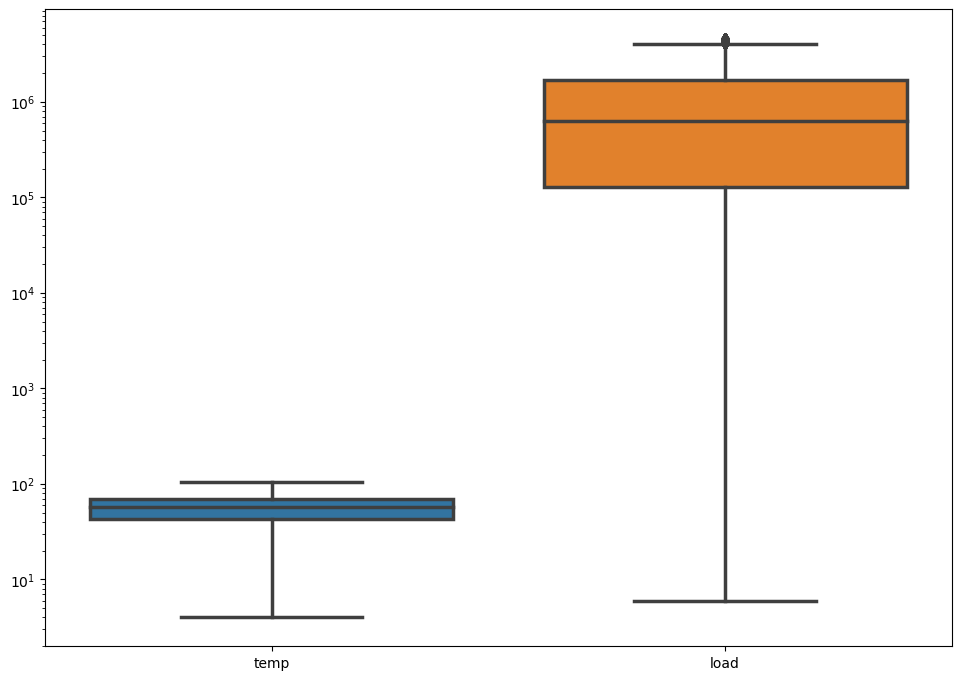

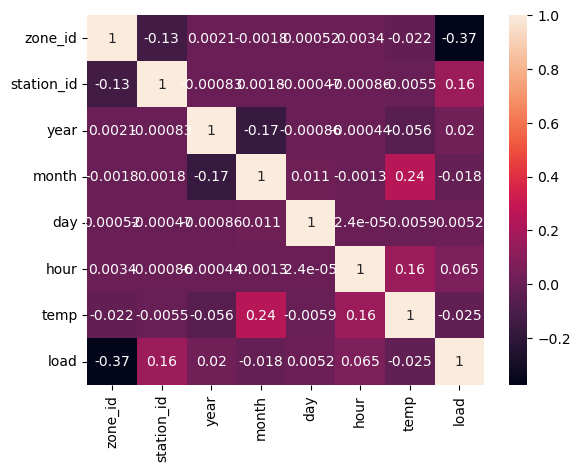

In [8]:
# The following method is used to get a better understanding of the data we're working with
print(zone_merged_df[['temp', 'load']].describe())

zone_merged_df = remove_outliers(zone_merged_df, 'temp')
zone_merged_df = remove_outliers(zone_merged_df, 'load')

# To check outliers
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
g = sns.boxplot(data=zone_merged_df[['temp', 'load']], linewidth=2.5, ax=ax)
g.set_yscale("log")
plt.show()

# To check correlation
relation = zone_merged_df.corr()
relation_index = relation.index
sns.heatmap(zone_merged_df[relation_index].corr(), annot=True)
plt.show()

## **Splitting the data into subsets**

The reason for using an 80:20:20 split is to have enough data for training, validation, and testing while still leaving a significant portion of data for the test set.

The training set is used to train the model on the data. The validation set is used to tune the hyperparameters of the model and prevent overfitting. The test set is used to evaluate the performance of the model on new, unseen data.

Using a smaller test set can result in higher variance in the evaluation of the model's performance. This means that the performance of the model on the test set may vary greatly depending on which samples are in the test set. Conversely, using a larger test set can result in higher bias in the evaluation of the model's performance. This means that the performance of the model on the test set may not accurately reflect its performance on new, unseen data.

An 80:20:20 split strikes a balance between having enough data for training, validation, and testing while still leaving enough data in the test set to accurately evaluate the model's performance on new, unseen data and was also a common split used in the course assingments.

In the following code block, shufflisng the data was considered by adding **"shuffle = True"** parameter to the **"train_test_split()"** function, but when tried the accuracy of the model did not increase to a degree where it was influential in the final result. 

In [9]:
# Data splitting 
data = df_to_bunch(zone_merged_df)
X = data.data
y = data.target

# Split the data into training/validation (80%) and test (20%) sets
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=3, shuffle = True)

# Split the training/validation set into training (80%) and validation (20%) sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=3, shuffle = True)

# Print the shapes of the resulting datasets
print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test set shape:", X_test.shape)

Training set shape: (490117, 7)
Validation set shape: (122530, 7)
Test set shape: (153162, 7)


# **Regressor**

In order to choose the algorithms to be used in the project, a list of different regressors was used, and their respective scores were obtained using default parameters for each regressor. At first the first idea was to use DecisionTreeRegressor and RandomForestRegressor as the values obtained with these were the highest from the regressors tested but given that both are based on decision trees, it was decided that it would be a good idea to choose regressors that weren't so alike. Also, it was found interesting to use a regressor that wasn't previously seen in class, such as AdaBoostRegressor. Therefore, in the rest of the project, the regressors that are going to be investigated are the **DecisionTreeRegressor** and the **AdaBoostRegressor**.

In [10]:
# Create a list of regression models
regressors = [LinearRegression(),
              Ridge(),
              Lasso(),
              ElasticNet(),
              DecisionTreeRegressor(),
              GradientBoostingRegressor(),
              AdaBoostRegressor(),
              RandomForestRegressor()]

# Train and evaluate each model
for regressor in regressors:
    # Fit the model to the data
    t0 = time.perf_counter()
    regressor.fit(X_train, y_train)
    t1 = time.perf_counter()

    # Print the model score
    print(f"{regressor.__class__.__name__} score: {regressor.score(X_train, y_train):.2f}, Time: {t1 - t0:0.4f} seconds")

LinearRegression score: 0.16, Time: 0.2882 seconds
Ridge score: 0.16, Time: 0.0683 seconds
Lasso score: 0.16, Time: 0.2165 seconds
ElasticNet score: 0.16, Time: 0.1738 seconds
DecisionTreeRegressor score: 1.00, Time: 2.9842 seconds
GradientBoostingRegressor score: 0.96, Time: 50.4210 seconds
AdaBoostRegressor score: 0.87, Time: 23.5382 seconds
RandomForestRegressor score: 1.00, Time: 133.2885 seconds


# **Cross Validation**

In  the following code block cross-validation approach is implemented to tune the hyperparameters of the machine learning algorithm.

The method **"GridSearchCV.()"** was applied to conduct a 5-fold cross validation on both regressors. This allows to obtain, from the parameter grid fed to the method, the hyperparameters that will produce a higher accuracy for each of the regressor investigated in this report.

In [11]:
#GridSearch

# Create a Gradient Boosting model
chosen_regressors = [DecisionTreeRegressor(), AdaBoostRegressor()]
best_params = []
# Define the hyperparameters to tune and their possible values
param_grid = [{"splitter": ["best", "random"],
            "max_depth": [20, None],
            "min_samples_split": [2, 3],
            "min_samples_leaf": [1, 2, 3],
            "min_weight_fraction_leaf": [0.0, 0.2],
            "max_leaf_nodes": [None, 50]},
            {"n_estimators": [50, 100],
            "learning_rate": [0.01, 0.1],
            "loss": ["linear", "square"]}]

for i in range(len(chosen_regressors)):
    t0 = time.perf_counter()
    # Use GridSearchCV for hyperparameter tuning with 5-fold cross-validation
    grid_search = GridSearchCV(chosen_regressors[i], param_grid[i], cv=5)
    grid_search.fit(X_train, y_train)
    t1 = time.perf_counter()
    print(f"Total 5-fold cross validation time for {chosen_regressors[i]} was: {t1 - t0:0.4f} seconds")    
    # Get the best hyperparameters
    best_params.append(grid_search.best_params_)
print('The optimal parameters for the DecisionTreeRegressor and AdaBoostRegressor obtained from the 5-fold cross validation are, respectively:')
print(best_params[0])
print(best_params[1])



Total 5-fold cross validation time for DecisionTreeRegressor() was: 216.6832 seconds
Total 5-fold cross validation time for AdaBoostRegressor() was: 1617.9722 seconds
The optimal parameters for the DecisionTreeRegressor and AdaBoostRegressor obtained from the 5-fold cross validation are, respectively:
{'max_depth': 20, 'max_leaf_nodes': None, 'min_samples_leaf': 3, 'min_samples_split': 3, 'min_weight_fraction_leaf': 0.0, 'splitter': 'best'}
{'learning_rate': 0.1, 'loss': 'linear', 'n_estimators': 50}


# **Regressor design and training**

Now that the optimal hyperparameters have been chose, we proceed to train the regressors and obtain the score values. For the DecisionTreeRegressor (DTR) and the AdaBoostRegressor (ABR).


Refressor used: <class 'sklearn.tree._classes.DecisionTreeRegressor'>
Training, Validation & Test scores for DTR: 0.9934086094660596, 0.9855531396996711 & 0.9853631197749309
Test R2: 0.9853631197749309
Test MSE: 17696587301.51331
Total training time for DTR: 1.9801 seconds


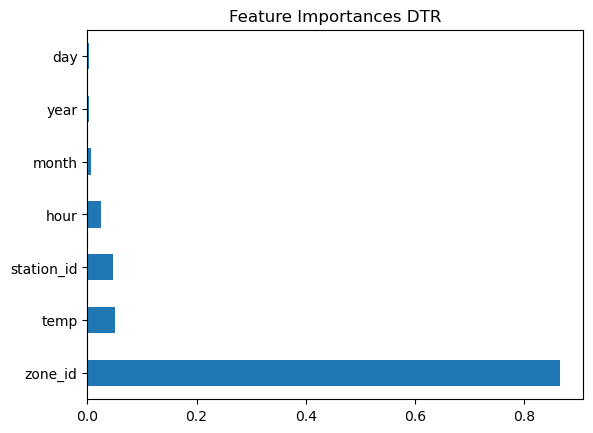

In [12]:
# Training DecisionTreeRegressor
#best_params_DTR = {'max_depth': None, 'max_leaf_nodes': None, 'min_samples_leaf': 3, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'splitter': 'best'}

t0 = time.perf_counter()

best_regr = DecisionTreeRegressor(**best_params[0])
print(f'Refressor used: {type(best_regr)}')

# Train regressor 
best_regr.fit(X_train, y_train)

# Obtain scores for data splits
train_score_DTR = best_regr.score(X_train, y_train)
val_score_DTR = best_regr.score(X_val, y_val)
test_score_DTR = best_regr.score(X_test, y_test)
print(
    f"Training, Validation & Test scores for DTR: {train_score_DTR}, {val_score_DTR} & {test_score_DTR}")

# Make predictions and obtain accuracy scores
y_test_pred = best_regr.predict(X_test)

test_r2 = r2_score(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
print('Test R2:', test_r2)
print('Test MSE:', test_mse)

t1 = time.perf_counter()
print(f"Total training time for DTR: {t1 - t0:0.4f} seconds")

# Feature importances graph
feat_importances = pd.Series(
    best_regr.feature_importances_, index=data.feature_names)
feat_importances.nlargest(7).plot(kind='barh')
plt.title('Feature Importances DTR')
plt.show()

In [13]:
# Get predicted values on test data
y_pred = best_regr.predict(X_test)

# Calculate prediction errors
errors = abs(100*(y_test - y_pred)/y_test)

# Sort errors in ascending order and get indices of top 10 errors
top10_smallest_errors_indices = errors.argsort()[:10] # Get examples from test data with top 10 errors
top10_smallest_errors = errors[top10_smallest_errors_indices]

# Print the examples with top 10 errors
print("Top 10 Smallest Prediction Errors:")
for i in range(10):
    print("Example {}: {}".format(i+1, top10_smallest_errors[i]))

Top 10 Smallest Prediction Errors:
Example 1: 0.0
Example 2: 0.000316203971319651
Example 3: 0.0003491005604683233
Example 4: 0.00042096680828949235
Example 5: 0.00048236084421990306
Example 6: 0.00048341302182965253
Example 7: 0.0005180874697436917
Example 8: 0.0006739982042343498
Example 9: 0.0006940487337518659
Example 10: 0.0007005357209893273


In [14]:
# Sort errors in descending order and get indices of top 10 errors
top10_errors_indices = errors.argsort()[::-1][:10] # Get examples from test data with top 10 errors
top10_errors = errors[top10_errors_indices]

# Get the top 10 examples with the biggest errors
y_test_top10 = y_test[top10_errors_indices]
y_pred_top10 = y_pred[top10_errors_indices]
top10_errors = errors[top10_errors_indices]

# Create a DataFrame with the relevant data
errors_df = pd.DataFrame({
    'zone_id': X_test[top10_errors_indices, 0],
    'station_id': X_test[top10_errors_indices, 1],
    'year': X_test[top10_errors_indices, 2],
    'month': X_test[top10_errors_indices, 3],
    'day': X_test[top10_errors_indices, 4],
    'hour': X_test[top10_errors_indices, 5],
    'predicted load': y_pred_top10,
    'true load': y_test_top10,
    'relative percentage absolute error': abs((y_test_top10 - y_pred_top10) / y_test_top10)
})

# Set the index to the example indices
errors_df.index = top10_errors_indices

# Sort by absolute value of relative percentage error
errors_df = errors_df.reindex(errors_df['relative percentage absolute error'].abs().sort_values(ascending=False).index)
print("Top 10 Biggest Prediction Errors:")
print(errors_df)

Top 10 Biggest Prediction Errors:
        zone_id  station_id  year  month  day  hour  predicted load  \
117823       11           8  2008      3    5    22     3837.818182   
125264       11           8  2007      4   13     5     2613.888889   
144323       19           6  2007     10    4    18   309202.250000   
29220        19           6  2005      9   27    22   596666.000000   
19619        19           6  2006      9    6    15   543926.576923   
30733        19           6  2007     10    2    23   453103.600000   
72447        19           6  2005      9   28     8   512997.193548   
11387        19           6  2004     11   17    11   525115.090909   
25870        19           6  2005      9   27    10   552836.296296   
17203        19           6  2004     11   17    12   525115.090909   

        true load  relative percentage absolute error  
117823         12                          318.818182  
125264         18                          144.216049  
144323      1507

Refressor used: <class 'sklearn.ensemble._weight_boosting.AdaBoostRegressor'>
Training, Validation & Test scores for GBR: 0.876300346385115, 0.8763056490456267 & 0.8762086677189191
Test R2: 0.8762086677189191
Test MSE: 149668787692.25192
Total training time ABR: 34.8560 seconds


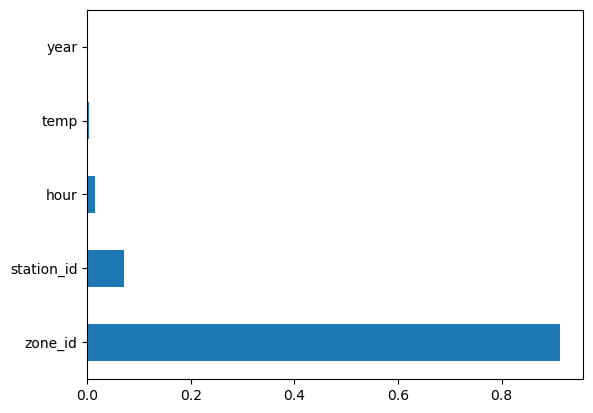

In [15]:
# Training AdaBoostRegressor
#best_params_ABR = {'learning_rate': 0.1, 'loss': 'square', 'n_estimators': 100}

t0 = time.perf_counter()

best_regr = AdaBoostRegressor(**best_params[1])
print(f'Refressor used: {type(best_regr)}')

# Train regressor 
best_regr.fit(X_train, y_train)

# Obtain scores for data splits
train_score_GBR = best_regr.score(X_train, y_train)
val_score_GBR = best_regr.score(X_val, y_val)
test_score_GBR = best_regr.score(X_test, y_test)
print(
    f"Training, Validation & Test scores for GBR: {train_score_GBR}, {val_score_GBR} & {test_score_GBR}")

# Make predictions and obtain accuracy scores
y_test_pred = best_regr.predict(X_test)

test_r2 = r2_score(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
print('Test R2:', test_r2)
print('Test MSE:', test_mse)

t1 = time.perf_counter()
print(f"Total training time ABR: {t1 - t0:0.4f} seconds")

# Feature importances graph
feat_importances = pd.Series(
    best_regr.feature_importances_, index=data.feature_names)
feat_importances.nlargest(5).plot(kind='barh')
plt.show()

In [16]:
# Get predicted values on test data
y_pred = best_regr.predict(X_test)

# Calculate prediction errors
errors = abs(100*(y_test - y_pred)/y_test)

# Sort errors in ascending order and get indices of top 10 errors
top10_smallest_errors_indices = errors.argsort()[:10] # Get examples from test data with top 10 errors
top10_smallest_errors = errors[top10_smallest_errors_indices]

# Print the examples with top 10 errors
print("Top 10 Smallest Prediction Errors:")
for i in range(10):
    print("Example {}: {}".format(i+1, top10_smallest_errors[i]))


Top 10 Smallest Prediction Errors:
Example 1: 0.0006748696458150308
Example 2: 0.000992226849312267
Example 3: 0.001235391987942451
Example 4: 0.0015617306609917538
Example 5: 0.0028286249859036227
Example 6: 0.0029379421995263345
Example 7: 0.003258836140087493
Example 8: 0.003504672747250054
Example 9: 0.003937353338172086
Example 10: 0.003963666136570167


In [17]:
# Sort errors in descending order and get indices of top 10 errors
top10_biggest_errors_indices = errors.argsort()[::-1][:10] # Get examples from test data with top 10 errors
top10_biggest_errors = errors[top10_biggest_errors_indices]

# Get the top 10 examples with the biggest errors
top10_biggest_errors_indices = errors.argsort()[::-1][:10]
y_test_top10 = y_test[top10_biggest_errors_indices]
y_pred_top10 = y_pred[top10_biggest_errors_indices]
errors_top10 = errors[top10_biggest_errors_indices]

# Create a DataFrame with the relevant data
errors_df = pd.DataFrame({
    'zone_id': X_test[top10_errors_indices, 0],
    'station_id': X_test[top10_errors_indices, 1],
    'year': X_test[top10_errors_indices, 2],
    'month': X_test[top10_errors_indices, 3],
    'day': X_test[top10_errors_indices, 4],
    'hour': X_test[top10_errors_indices, 5],
    'predicted load': y_pred_top10,
    'true load': y_test_top10,
    'relative percentage absolute error': abs(100 * (y_test_top10 - y_pred_top10) / y_test_top10)
})

# Set the index to the example indices
errors_df.index = top10_biggest_errors_indices

# Sort by absolute value of relative percentage error
errors_df = errors_df.reindex(errors_df['relative percentage absolute error'].abs().sort_values(ascending=False).index)
print("Top 10 Biggest Prediction Errors:")
print(errors_df)

Top 10 Biggest Prediction Errors:
        zone_id  station_id  year  month  day  hour  predicted load  \
117823       11           8  2008      3    5    22   514253.483488   
125264       11           8  2007      4   13     5   514253.483488   
26049        19           6  2007     10    4    18   514253.483488   
30094        19           6  2005      9   27    22   514253.483488   
68757        19           6  2006      9    6    15   514253.483488   
135404       19           6  2007     10    2    23   514253.483488   
52841        19           6  2005      9   28     8   514253.483488   
35620        19           6  2004     11   17    11   514253.483488   
74996        19           6  2005      9   27    10   514253.483488   
61183        19           6  2004     11   17    12   514253.483488   

        true load  relative percentage absolute error  
117823         12                        4.285346e+06  
125264         18                        2.856864e+06  
26049         60

#	**Observations and comparisons**

The design process for building a Regressor involves several steps and considerations:

- **Data Preparation**: This step involves loading and preprocessing the dataset. This includes tasks such as handling missing values, encoding categorical variables, and normalizing or scaling numeric features. In this project we've restructures the data as well as removed outliers from the dataset.

- **Feature Selection**: It’s important to select relevant features for the regression task. This can be done through various techniques such as domain knowledge, feature importance analysis, or feature selection algorithms. Our study uses all features from the dataset to obtain the prediction

- **Hyperparameter Tuning**: The regressors used have several hyperparameters that need to be tuned for optimal performance. Careful experimentation with different hyperparameter values and their impact on model performance is necessary. In this project a 5-fold cross validation has been conducted which is a good way of obtaining obtimal hyperparameters but requires time to conduct.

- **Model Evaluation**: It’s important to evaluate the performance of the regresors using appropriate evaluation metrics such as mean squared error (MSE), root mean squared error (RMSE), or R-squared (R2) score. This allows us to assess the accuracy and generalization capability of the model.

- **Overfitting Prevention**: regresor models are prone to overfitting so the design has to take into account this problem and act accordingly.

- **Model Interpretability**: the regressor models used are generally considered as black-box models, which means they may lack interpretability. However, some techniques such as feature importance analysis can provide insights into which features are most influential in making predictions.

## **Algorithms:**

- **DecisionTreeRegressor**: The DecisionTreeRegressor is a non-parametric model that uses a tree structure to make decisions based on splitting the data into branches that optimize a certain criterion, such as minimizing the mean squared error or maximizing the explained variance. The tree is built recursively by partitioning the data into subsets based on the value of a single feature at each node, until a stopping criterion is met, such as reaching a maximum depth or a minimum number of samples in a leaf.
- **AdaBoostRegressor**: The AdaBoostRegressor is an ensemble method that combines multiple weak learners, such as decision trees, into a strong learner. It works by iteratively fitting a weak model on the data and adjusting the weights of the samples that are misclassified by increasing their importance in the next iteration, until a predefined number of models are trained or a threshold accuracy is reached. The final prediction is the weighted sum of the individual model predictions.

### **Advantages:**

- **DecisionTreeRegressor**:
    - Easy to interpret and visualize the decision-making process.
    - Nonlinear relationships can be captured in the data.
    - Robust to missing values and outliers.
    
- **AdaBoostRegressor**:
    - Can improve the performance of a weak model by combining multiple models.
    - Reduces overfitting by adding a penalty to the misclassified samples.
    - Can handle both linear and nonlinear relationships in the data.

### **Disadvantages:**

- **DecisionTreeRegressor**:
    - Prone to overfitting, especially when the tree is deep or the data is noisy.
    - Sensitive to small changes in the data and can produce different trees for different random samples.
    - Cannot capture complex interactions between features.

- **AdaBoostRegressor**:
    - Can be sensitive to noisy or outlier data.
    - Can be computationally expensive and slow to train, especially when using a large number of weak models.
    - Requires a good choice of weak models and hyperparameters to achieve good performance.

## **Use cases:**

- **DecisionTreeRegressor**:

    - Prediction tasks with a few features that have clear nonlinear relationships with the target variable.
    - When the interpretability of the model is important.
    - When the data contains missing values or outliers.

- **AdaBoostRegressor**:

    - When there is a need to improve the performance of a weak model.
    - When the data contains both linear and nonlinear relationships.
    - When the goal is to reduce overfitting and improve generalization performance.

In summary, DecisionTreeRegressor and AdaBoostRegressor have different algorithms, strengths, weaknesses, and use cases. DecisionTreeRegressor is a simple, interpretable model that can capture nonlinear relationships in the data and is robust to missing values and outliers, but can overfit and struggle with complex interactions between features. AdaBoostRegressor is an ensemble method that can improve the performance of a weak model by combining multiple models and is effective at reducing overfitting, but can be sensitive to noisy data and require more computational resources. The choice of which model to use will depend on the specific characteristics of the data and the requirements of the problem at hand.

Comparing and contrasting the results of the DecisionTreeRegressor and the AdaBoostRegressor is essential to evaluate their performance. It is important to analyze the error patterns to understand if both algorithms make similar errors on the same examples from the test data. Additionally, it is essential to identify examples where one algorithm outperforms the other to understand their strengths and weaknesses.

The overall performance of the algorithms can be compared by evaluating the score values of the final models for each dataset. It is important to consider the performance of the models on the training, validation, and test datasets to ensure that the model generalizes well to unseen data. If we compare the test scores from both algorithms we can see that the DecisionTreeRegressor (DTR) has a higuer score than the AdaBoostRegressor (ABR) coming in at 0.985 and 0.865 respectively. On the other hand, an as can be seen in the following table, the DTR requires less time to train than the ABR. It is also worth mentioning that the most infleuntial feature for both algorithms is the "Zone_id" followed by the "Temperature".

## **Model comparison table**

| Parameters        | DecisionTreeRegressor | AdaBoostRegressor |
| :---------------: | :-------------------: | :---------------: |
| Training Score    | 0.996                 | 0.865             |
| Validation Score  | 0.985                 | 0.865             |
| Test Score        | 0.985                 | 0.865             |
| R2 Score          | 0.985                 | 0.865             |
| Biggest error     | 311.33                | 4.285e+04         |
| Smallest error    | 0.000                 | 0.000             |
| Training time     | 3.142                 | 83.019            |

# **Final Load prediction**

The following code clock conducts the prediction for the first week of June 2008 and outputs the data in the required format.

In [18]:
# Load prediction

load_data = pd.read_csv(
    '/Users/arturogalofre/Desktop/IIT/2nd_Term/ECE563_AISmartGrid/Code/FinalProject/Load_history_final.csv')

temp_data = pd.read_csv(
    '/Users/arturogalofre/Desktop/IIT/2nd_Term/ECE563_AISmartGrid/Code/FinalProject/Temp_history_final.csv')


# Melt the temperature columns into a new DataFrame
temp_df = pd.melt(
    temp_data,
    id_vars=['station_id', 'year', 'month', 'day'],
    value_vars=['h{}'.format(i) for i in range(1, 25)],
    var_name='hour',
    value_name='temp'
)
temp_df['hour'] = temp_df['hour'].str.slice(start=1).astype(int)

# Melt the load columns into a new DataFrame
load_df = pd.melt(
    load_data,
    id_vars=['zone_id', 'year', 'month', 'day'],
    value_vars=['h{}'.format(i) for i in range(1, 25)],
    var_name='hour',
    value_name='load'
)
load_df['hour'] = load_df['hour'].str.slice(start=1).astype(int)

zone_to_stat={1: 7, 2: 7, 3: 9, 4: 9, 5: 2, 6: 9, 7: 9, 8: 10, 9: 8, 10: 11, 11: 8, 12: 6, 13: 3, 14: 8, 15: 10, 16: 4, 17: 9, 18: 4, 19: 6, 20: 9}

# Create array from temperature dataframe
load_arr = load_df.to_numpy()

# Change the station values for the corresponding zones
zone_arr = load_arr[:, 0]
mapped_array = [zone_to_stat[val] for val in zone_arr]
mapped_array1 = np.array(mapped_array)
new_arr = np.hstack((load_arr[:, :1], mapped_array1.reshape(-1, 1), load_arr[:, 1:]))
load_df = pd.DataFrame(new_arr, columns = ['zone_id','station_id','year', 'month', 'day','hour','load'])

# Merge both dataframes to a single one containing temperature and load values
zone_merged_df = pd.merge(load_df, temp_df, on=['year', 'month', 'day','hour','station_id'], how='left')[['zone_id', 'station_id', 'year', 'month', 'day','hour','temp','load']]


df_t = zone_merged_df[(zone_merged_df['year']==2008) & (zone_merged_df['month']==6) & (zone_merged_df['day']<=7)]
df_t = df_t.sort_values(['zone_id', 'hour'])

array_t = df_t.to_numpy()
X = array_t[:, :-1]
y_pred = best_regr.predict(X)
y_pred=y_pred.reshape(-1,1)
array_t=np.append(X, y_pred, axis=1)

df = pd.DataFrame(array_t[:,[0,2,3,4,5,7]], columns=['zone_id', 'year', 'month', 'day','hour','load'])

# pivot the dataframe to convert hour column to h1 to h24 columns
pivoted_df = df.pivot_table(index=['zone_id', 'year', 'month', 'day'], 
                            columns='hour', 
                            values='load', 
                            aggfunc='first').reset_index()

# rename the h1 to h24 columns
pivoted_df.columns = ['zone_id', 'year', 'month', 'day'] + ['h{}'.format(h) for h in range(1, 25)]

pivoted_df.to_csv('output.csv', index=False)

# **Conclusion**
n this project, the goal was to use load and temperature data from utility companies in the US to predict load values for different zones for the week of June 1-7, 2008. The project involved pre-processing and cleaning the data, determining correlations between temperature stations and load values, splitting the data into training and testing sets, choosing and tuning two different machine learning algorithms, and analyzing the results.

Through this project, we learned about the importance of pre-processing and cleaning data to improve the accuracy of the machine learning models. We also learned about different techniques for feature engineering and the importance of selecting appropriate features for a given problem. Additionally, we gained experience in selecting and tuning different machine learning algorithms to achieve the best possible performance.

This project is useful because it allows us to predict load values for different zones, which can be helpful for utility companies to plan and manage their energy resources more efficiently. By using temperature data to predict load values, companies can better anticipate the demand for energy in different areas, which can help them optimize their resource allocation.

Further research could be conducted to improve the accuracy and efficiency of the machine learning algorithms used in this project. For example, different algorithms and techniques for feature engineering could be explored, and the data could be pre-processed in different ways to see how it affects the performance of the models. Additionally, further research could be conducted to determine the optimal amount of data to use for training and testing the models, and to determine how to reduce the time required for model training and prediction while maintaining accuracy.

#	**Apendix**

The sumarized code that creates the output file is presented in the following code block.

In [ ]:
# import libraries
import time
import pandas as pd
import numpy as np
from sklearn.utils import Bunch
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor

############################## Functions ####################################################################################################

# Removing outliers


def remove_outliers(df, column_name, sd_multiplier=3):

 # Compute the mean and standard deviation of the column
    column_mean = df[column_name].mean()
    column_std = df[column_name].std()

    # Compute the lower and upper bounds for outlier removal
    lower_bound = column_mean - (sd_multiplier * column_std)
    upper_bound = column_mean + (sd_multiplier * column_std)

    # Create a copy of the DataFrame with outliers and zeros removed
    cleaned_df = df.loc[(df[column_name] > lower_bound) & (
        df[column_name] < upper_bound) & (df[column_name] != 0)].copy()

    return cleaned_df

# Dataframe to Bunch


def df_to_bunch(df):
    # Get the feature names
    feature_names = df.columns.tolist()

    # Get the target variable name
    target_name = feature_names.pop(-1)

    # Get the feature data and target data
    data = df[feature_names].values
    target = df[target_name].values

    # Create a Bunch object
    bunch = Bunch(data=data, target=target,
                  feature_names=feature_names, target_names=target_name)

    return bunch


################################### Load the dataset ########################################################################################
t0 = time.perf_counter()

temp_data = pd.read_csv(
    '/Users/arturogalofre/Desktop/IIT/2nd_Term/ECE563_AISmartGrid/Code/FinalProject/Temp_history_final.csv')
load_data = pd.read_csv(
    '/Users/arturogalofre/Desktop/IIT/2nd_Term/ECE563_AISmartGrid/Code/FinalProject/Load_history_final.csv')

# Melt the temperature columns into a new DataFrame
temp_df = pd.melt(
    temp_data,
    id_vars=['station_id', 'year', 'month', 'day'],
    value_vars=['h{}'.format(i) for i in range(1, 25)],
    var_name='hour',
    value_name='temp'
)
temp_df['hour'] = temp_df['hour'].str.slice(start=1).astype(int)

# Melt the load columns into a new DataFrame
load_df = pd.melt(
    load_data,
    id_vars=['zone_id', 'year', 'month', 'day'],
    value_vars=['h{}'.format(i) for i in range(1, 25)],
    var_name='hour',
    value_name='load'
)
load_df['hour'] = load_df['hour'].str.slice(start=1).astype(int)

zone_to_stat = {1: 7, 2: 7, 3: 9, 4: 9, 5: 2, 6: 9, 7: 9, 8: 10, 9: 8, 10: 11,
                11: 8, 12: 6, 13: 3, 14: 8, 15: 10, 16: 4, 17: 9, 18: 4, 19: 6, 20: 9}

# Create array from temperature dataframe
load_arr = load_df.to_numpy()

# Change the station values for the corresponding zones
zone_arr = load_arr[:, 0]
mapped_list = [zone_to_stat[val] for val in zone_arr]
mapped_array = np.array(mapped_list)
new_arr = np.hstack(
    (load_arr[:, :1], mapped_array.reshape(-1, 1), load_arr[:, 1:]))
zs_load_df = pd.DataFrame(new_arr, columns=[
                          'zone_id', 'station_id', 'year', 'month', 'day', 'hour', 'load'])

# Merge both dataframes to a single one containing temperature and load values
zone_merged_df = pd.merge(zs_load_df, temp_df, on=['year', 'month', 'day', 'hour', 'station_id'], how='left')[
    ['zone_id', 'station_id', 'year', 'month', 'day', 'hour', 'temp', 'load']]

zone_merged_df_t = remove_outliers(zone_merged_df, 'temp')
zone_merged_df_t = remove_outliers(zone_merged_df, 'load')

# Data splitting
data = df_to_bunch(zone_merged_df_t)
X = data.data
y = data.target

# Split the data into training/validation (80%) and test (20%) sets
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=3, shuffle=True)

# Split the training/validation set into training (80%) and validation (20%) sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=3, shuffle=True)

################################## Training DecisionTreeRegressor ###########################################################################

best_params_DTR = {'max_depth': None, 'max_leaf_nodes': None, 'min_samples_leaf': 3,
                   'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'splitter': 'best'}

best_regr = DecisionTreeRegressor(**best_params_DTR)
print(f'Refressor used: {type(best_regr)}')

# Train regressor
best_regr.fit(X_train, y_train)

# Obtain scores for data splits
train_score_DTR = best_regr.score(X_train, y_train)
val_score_DTR = best_regr.score(X_val, y_val)
test_score_DTR = best_regr.score(X_test, y_test)
print(
    f"Training, Validation & Test scores for DTR: {train_score_DTR}, {val_score_DTR} & {test_score_DTR}")

# Make predictions and obtain accuracy scores
y_test_pred = best_regr.predict(X_test)

test_r2 = r2_score(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
print('Test R2:', test_r2)
print('Test MSE:', test_mse)

# Load prediction
df_t = zone_merged_df[(zone_merged_df['year'] == 2008) & (
    zone_merged_df['month'] == 6) & (zone_merged_df['day'] <= 7)]
df_t = df_t.sort_values(['zone_id', 'hour'])


array_t = df_t.to_numpy()
X = array_t[:, :-1]
y_pred = best_regr.predict(X)
y_pred = y_pred.reshape(-1, 1)
array_t = np.append(X, y_pred, axis=1)

df = pd.DataFrame(array_t[:, [0, 2, 3, 4, 5, 7]], columns=[
                  'zone_id', 'year', 'month', 'day', 'hour', 'load'])

# pivot the dataframe to convert hour column to h1 to h24 columns
pivoted_df = df.pivot_table(index=['zone_id', 'year', 'month', 'day'],
                            columns='hour',
                            values='load',
                            aggfunc='first').reset_index()

# rename the h1 to h24 columns
pivoted_df.columns = ['zone_id', 'year', 'month',
                      'day'] + ['h{}'.format(h) for h in range(1, 25)]

pivoted_df.to_csv('Load_prediction.csv', index=False)

t1 = time.perf_counter()
print(f"Total running time: {t1 - t0:0.4f} seconds")


print('output file with name "Load_prediction.csv" was created')